# VitSigNet Demo Notebook

First, download the pretrained model checkpoints from [here](https://drive.google.com/file/d/13BVAsz4TMybx4xopPSh0ua_l4YwN1jkT/view?usp=drive_link) and [here](https://drive.google.com/file/d/1zxYfElWBdUWRzhPaDLQml5lFrUORcube/view?usp=drive_link). Also download the CEDAR dataset, from [here](https://drive.google.com/file/d/1Ns3cKpfhEwWb_3F7maCkrRML0exXl8py/view?usp=drive_link).

This notebook demonstrates how to validate and test the ViTPose model using the CEDAR dataset. Ensure you have the model checkpoint and the dataset downloaded before proceeding.

In [1]:
import torch
import os
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from model_defs import ViTPose, MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from torch.utils.data import Dataset
from itertools import combinations, product
from tqdm import tqdm
import datetime
import numpy as np
import torch.nn.functional as F
from torchvision.models import resnet50
from sklearn.metrics import roc_auc_score

/home/jamesemi/Desktop/james/adl/ViTPose_pytorch/adl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset Preparation

Define the dataset class and create data loaders for the test dataset:

In [2]:
class DupletDatasetCEDAR(Dataset):
    def __init__(self, base_dir, signers, transform=None):
        """
        Initialize the dataset with the directory of images and transforms.
        base_dir: The directory that contains subdirectories of original and forgery images.
        transform: Transformations to apply to each image.
        """
        self.transform = transform
        self.signers = signers
        self.pairs, self.labels = self._create_pairs(base_dir)
        self.base_dir = base_dir

    def _create_pairs(self, base_dir):
        pairs = []
        labels = []
        # Walk through the directory
        for signer in self.signers:
            subdir = os.path.join(base_dir, signer)
            originals = [os.path.join(subdir, f) for f in os.listdir(subdir) if 'original' in f]
            forgeries = [os.path.join(subdir, f) for f in os.listdir(subdir) if 'forgeries' in f]

            original_pairs = list(combinations(originals, 2))
            for pair in original_pairs:
                pairs.append(pair)
                labels.append(0)

            forgery_pairs = list(product(originals, forgeries))
            for pair in forgery_pairs:
                pairs.append(pair)
                labels.append(1)

        return pairs, labels
    
    def __getitem__(self, index):
        img1_path, img2_path = self.pairs[index]
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        label = torch.tensor([self.labels[index]], dtype=torch.float32)
        return [img1, img2], label

    def __len__(self):
        return len(self.pairs)
    
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# TODO - Adjust the directory path to your test dir
test_dir = '/home/jamesemi/Desktop/james/adl/ViTPose_pytorch/datasets/CEDAR/test'
test_signers = [name for name in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, name))]
test_dataset = DupletDatasetCEDAR(test_dir, signers=test_signers, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load the pre-trained model from the checkpoint:

In [7]:
# TODO - Adjust the checkpoint path
checkpoint_path = '/home/jamesemi/Desktop/james/adl/ViTPose_pytorch/vitpose_lr0.0001_epoch17_valloss0.0045_20240425-222707.pth'
model = ViTPose().to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
model.eval()
print("VitPose Model loaded successfully.")

VitPose Model loaded successfully.


In [10]:
# TODO - Adjust the checkpoint path
checkpoint_path = '//home/jamesemi/Desktop/james/adl/ViTPose_pytorch/mlp_model_epoch12_lr1e-06_valloss0.0230_20240426-134537.pth'
mlp_model = MLPClassifier(input_dim=5120, hidden_dim=512, output_dim=1).to(device)
mlp_model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
mlp_model.eval()
print("MLP Model loaded successfully.")

MLP Model loaded successfully.


### Model Testing

Run the test loop to evaluate the model:


In [15]:
def test_model(model, mlp_model, test_loader, device):
    model.eval()
    mlp_model.eval()
    pos_distances, neg_distances = [], [] 
    distances = []
    labels = []
    with torch.no_grad():
        for images, targets in tqdm(test_loader):
            images = [image.to(device) for image in images]
            targets = targets.to(device)
            output1 = model(images[0])
            output2 = model(images[1])
            distance = F.pairwise_distance(output1.view(output1.shape[0], -1), output2.view(output1.shape[0], -1), keepdim=True)
            # distance = F.pairwise_distance(output1.view(output1.shape[0], -1), output2.view(output2.shape[0], -1)).squeeze().cpu().numpy()
            distances.append(distance.item())
            if targets.item() == 1:
                pos_distances.append(distance.item())
            else:
                neg_distances.append(distance.item())
            labels.append(targets.item())

    data = [pos_distances, neg_distances]

    auc_score = roc_auc_score(labels, np.array(distances) > 0.5)  # Calculate AUC based on the similarity scores

    print(f"AUC Score: {auc_score}")

    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=data)
    plt.xticks([0, 1], ['Forgery', 'Original'])
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    #TODO - adjust filename/path 
    filename = f"/home/jamesemi/Desktop/james/adl/ViTPose_pytorch/figs/violin_plot_{timestamp}.png"
    plt.savefig(filename, dpi=300)
    plt.show
    # return pos_distances, neg_distances, auc_score

100%|██████████| 4260/4260 [01:27<00:00, 48.90it/s]


AUC Score: 0.9963541666666667


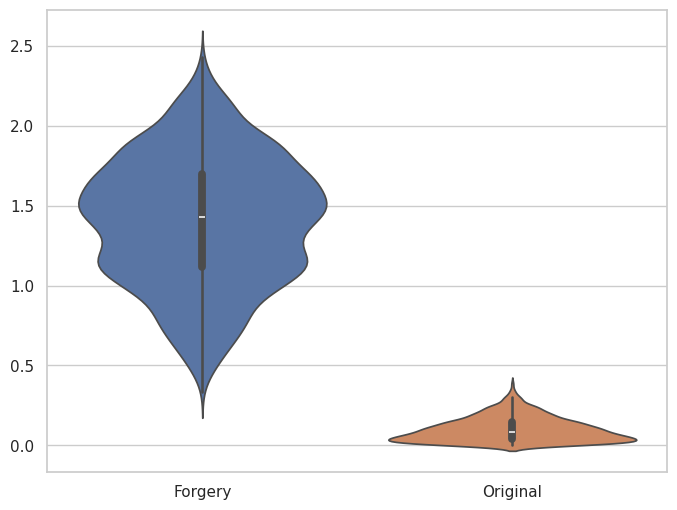

In [16]:
test_model(model, mlp_model, test_loader, device)

As seen from the violin plot, the model is able to clearly differentiate between the original-forgery pairs, and identifies the original-original pairs as highly similar. The AUC score of 0.996 also points to the well-honed discriminative abilities of the trained model. 